## Дифференцируемое програмирование

На этом семинаре будет реализовываться система распознавания рукописных слов, основанная на совмещении алгоритмов предсказания (динамическое программирование) и глубинного обучения. Мы будем использовать датасет Stanford OCR (http://ai.stanford.edu/~btaskar/ocr/), состоящий из слов на английском языке и изображений рукописных букв.

Для начала загрузим и подготовим данные. Для распаковки необходим gunzip. Пользователям Windows нужно скачать и распаковать датасет вручную.

In [1]:
!rm -rf letter.data
!wget http://ai.stanford.edu/~btaskar/ocr/letter.data.gz
!gunzip letter.data.gz

--2019-03-24 19:11:11--  http://ai.stanford.edu/~btaskar/ocr/letter.data.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1329012 (1.3M) [application/x-gzip]
Saving to: ‘letter.data.gz’

letter.data.gz      100%[===================>]   1.27M   324KB/s    in 4.0s    

2019-03-24 19:11:16 (324 KB/s) - ‘letter.data.gz’ saved [1329012/1329012]



In [2]:
from utils import prepare_data
train_x, train_y, test_x, test_y, val_x, val_y, le = prepare_data()

Каждый элемент датасета содержит данные об одном слове. Списки $*\_x[i]$ содержат numpy массивы размера [word_len, 1, 32, 32], содержащие изображения рукописных букв. Списки $*\_y[i]$ содержат numpy массивы размера [word_len] с метками для каждого изображения.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
%matplotlib inline

Изображения выглядят следующим образом. Метки классов уже сконвертированы в числа для использования.

Обратите внимание, что в нашем датасете первые буквы в каждом слове обрезаны и не используются (это не баг, а сделано специально, потому что первая буква часто бывает заглавной и, соответственно, её вариабельность сильно выше).

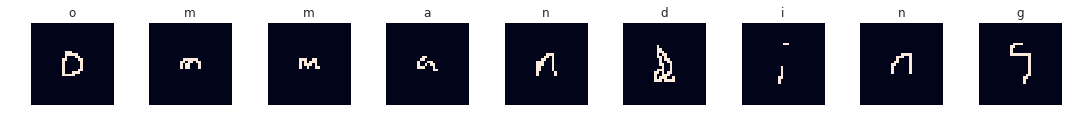

In [4]:
sb.set()
fig, ax = plt.subplots(1, train_x[0].shape[0], figsize=(15,15))
ax = np.array(ax)

word = ''.join(le.inverse_transform(train_y[0]))
for idx in range(train_x[0].shape[0]):
    ax[idx].set_title(word[idx])
    ax[idx].axis('off')
    ax[idx].imshow(train_x[0][idx,0,:,:])
plt.tight_layout()

### Score функция и правдоподобие

<img src="Structure-of-linear-chain-conditional-random-field.png">

Мы будем использовать модель вида цепочка (то есть нас будут интересовать только связи между соседними буквами) со следующей score функцией:
$$
F(Y| X, \Theta) = \sum\limits_{i=0}^{L-1} U(x_i, y_i) + \sum\limits_{i=0}^{L-2} W(y_{i}, y_{i+1})
$$

$\Theta$ содержит параметры унарных $U$ и парных $W$ потенциалов. На этом семинаре для унарных потенциалов мы будем использовать простую нейросеть для классификации изображения (как для MNIST), а парные потенциалы параметризуем при помощи матрицы размера $26 \times 26$ (обратите внимание, что парные потенциалы зависят только от меток, т.е., не зависят непосредственно от изображений).
$U$ унарные потенциалы отвечают за совместимость метки $y_i$ и входного изображения буквы $x_i$. Парные потенциалы показывают насколько вероятно сочетание букв $(y_i, y_{i+1})$. 

Используя score функцию $F$, мы можем задать распределение вероятностей над всеми возможными разметками последовательности $X$ (это распределение связано с графической моделью Conditional Random Field, CRF):
$$
P(Y| X,\Theta) = \frac{1}{Z(\Theta)} \exp\{F(Y| X, \Theta)\}
$$

### Предсказание (0.3 балла)
Для фиксированных значений параметров $\Theta$ предсказание может быть сделано, например, при помощи максимизации score функции $F$ (соответствует моде распределения над разметками). Для функций, связи между переменными в которых образуют граф вида цепочка (возможно для любого дерева), задача максимизации может быть решена точно за полиномиальное время при помощи метода динамического программирования.

Выведем конкретный алгоритм, используя подход динамического программирования для решения задачи максимизации score функции:
$$
\max_{Y} F(Y|X,\Theta) = \max_{Y} \left[ \sum\limits_{i=0}^{L-1} U(x_i, y_i) + \sum\limits_{i=0}^{L-2} W(y_{i}, y_{i+1}) \right]
$$

Выполняя алгебраические преобразования, задачу можно переписать следующим образом:
$$
\max_{Y} \left[ \sum\limits_{i=0}^{L-1} U(x_i, y_i) + \sum\limits_{i=0}^{L-2} W(y_{i}, y_{i+1}) \right] = \max_{y_0} \left[U(x_0, y_0) + \max_{y_1,...,y_{L-1}}\left( W(y_0, y_1) + \sum\limits_{i=1}^{L-1} U(x_i, y_i) + \sum\limits_{i=1}^{L-2} W(y_{i}, y_{i+1}) \right) \right]
$$

В качестве подзадач динамического программирования будем использовать внутренние максимумы. Обозначим через $V_j(y_j)$ такой максимум по переменным с индексами большими чем $j$, т.е.,
$$
V_j(y_j) = U(x_j, y_j) + \max_{y_{j+1},...,y_{L-1}}\left( W(y_j, y_{j+1}) + \sum\limits_{i=j+1}^{L-1} U(x_i, y_i) + \sum\limits_{i=j+1}^{L-2} W(y_{i}, y_{i+1}) \right).
$$
Динамическое программирование основано на интеративном вычислении $V_j(y_j)$ на основе ранее вычисленных значений. Используется следующая формула пересчёта:
$$
V_j(y_j) = U(x_j, y_j) + \max_{y_{j+1}}\left[ W(y_j, y_{j+1}) + V_{j+1}(y_{j+1}) \right].
$$
Инициализировать пересчёт можно так: $V_{L-1}(y_{L-1}) = U(x_{L-1}, y_{L-1})$. Значение score на наилучшей конфигурации (решение задачи) можно найти при помощи максимизации $\max_{y_0} [V_0(y_0)]$.

Используя сохраненные индексы максимумов в каждой из задач максимизации, можно сделать проход в обратном направлении и восстановить оптимальную разметку.

In [5]:
import torch
import torch.nn as nn

NUM_LABELS = 26

In [ ]:
def dynamic_programming(U, W):
    """
    Parameters:
        U: unary potentials, torch tensor shape (len_word, NUM_LABELS)
        W: pairwise potentials, torch tensor shape (NUM_LABELS, NUM_LABELS)
    
    Returns:
        arg_classes: argmaximum, torch long tensor shape (len_word)
    """
    L = U.size(0)
    V, argmax = torch.zeros(L, NUM_LABELS),\
                torch.zeros(L, NUM_LABELS)
    
    ### code starts here ###
    V[L - 1] = U[L - 1]
    for i in range(L - 1, -1, -1):
        V[i] = U[i]
        iter_max, argmax[i + 1] = torch.max(W + V[i + 1].view(1, -1), dim=1)
        V[i] += iter_max    
        
    arg_classes = torch.zeros(L).long()
    arg_classes[0] = torch.argmax(V[0])
    
    for step in range(L):
        
    
    ### code ends here ###

    return arg_classes.long()

Если все реализовано верно, вы должны получить вывод: "nconsequential"

In [ ]:
U = torch.load('unary_example.pth')
W = torch.load('pairwise_example.pth')
pred = dynamic_programming(U, W)
pred = [int(i) for i in pred]
print(''.join(le.inverse_transform(pred)))

Обратите внимание, что если делать предсказание только по унарным потенциалам, то алгоритм делает ошибки.

In [ ]:
_, u_labels = U.max(1)
u_labels = [int(i) for i in u_labels]
print(''.join(le.inverse_transform(u_labels)))

## Настройка параметров $\Theta$ при помощи структурного метода опорных векторов (0.3 балла)
Для настройки параметров $\Theta$ будем использовать структурный метод опорных векторов (Structured SVM, SSVM). Интуитивно оптимизация данного функционала позволит обеспечить высокий score на правильных разметках и низкий score на неправильных. Функция потерь SSVM на одном объекте выборки $X$, $Y$ выглядит так:
$$
\max_{Y'} \left[\Delta(Y,Y') + F(Y',X,\Theta)\right] - F(Y,X,\Theta).  
$$
Здесь $\Delta(Y,Y')$ - это функция, обобщающая отстут (margin) из классического SVM. Мы будет к качестве $\Delta$ использовать нормированное расстояние Хэмминга между последовательностями $Y$ и $Y'$, т.е. $\Delta(Y,Y') = \frac{1}{L}\sum\limits_{i=1}^{L} [y_i \neq y_i']$.

Задача максимизации, возникающая в рамках функции потерь, может быть решена при помощи уже реализованного алгоритма динамического программирования (добавление функции $\Delta$ в данном случае не усложняет задачу поскольку не менят структуру графа). 
Для добавления $\Delta$ в score фунцию достаточно добавить $\frac{1}{L}$ ко всем унарным потенциалам, соответствующим неправильным меткам.

Процедура обучения (настройки параметров $\Theta$) состоит в минимизации функции потерь (усредненной по обучающей выборке) по $\Theta$ при помощи методов стохастической оптимизации. При обработке каждого элемента выборки нужно решать задачу максимизации $F+\Delta$. После нахождения оптимальной конфигурации (argmax) достаточно подставить полученные $Y'$ и вести оптимизацию по $\Theta$ опуская слагаемое отвечающее $\Delta$. На лекции методы этой группы назывались "структурным пулингом".

Сначала нужно реализовать решение задачи максимизации из функции потерь SSVM (loss-augmented inference) при помощи вызова ранее реализованного алгоритма динамического программирования. Для тестирования кода добавьте возможность умножения расстояния Хэмминга на вес weight.

In [ ]:
def loss_aug_inference(U, W, target, weight=1.0):
    """
    Parameters:
        U: unary potentials, torch tensor shape (len_word, NUM_LABELS)
        W: pairwise potentials, torch tensor shape (NUM_LABELS, NUM_LABELS)
        target: true configuration, torch long tensor shape (len_word)
        weight: (for debug) put more weight on the loss term
    Returns:
        arg_classes: argmaximum, torch long tensor shape (len_word)
    """
    ### code starts here ###
    
    ### code ends here ###
    return arg_classes.long()

In [ ]:
U = torch.load('unary_example.pth')
W = torch.load('pairwise_example.pth')
target = torch.LongTensor([13, 2, 14, 13, 18, 4, 16, 20, 4, 13, 19, 8, 0, 11])
pred = loss_aug_inference(U, W, target, weight=60.0)
correct = torch.LongTensor([13,2, 14, 13, 18, 5, 14, 21, 4, 13, 19, 8, 13, 2])
assert pred.eq(correct).sum() == correct.numel(), "Check your loss_aug_inference"

### Унарные потенциалы
Для извлечения унарных потенциалов будем использовать нейросеть вида LeNet. Для экономии времени семинара сеть обучена заранее (стандартная схема для MNIST, но с 26 классами).

Стоит так же заметить, что unary network без использования парных потенциалов достигает качества на валидации 0.92 (точность предсказания всех символов датасета).

In [ ]:
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(5 * 5 * 20, 140)
        self.fc2 = nn.Linear(140, 26)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 5 * 5 * 20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

unary_net = LeNet()
unary_net.load_state_dict(torch.load('state_dict.pth'))

### Обучение

Для вычисления функции потерь SSVM необходимо реализовать подсчет score функции.

In [ ]:
def score_function(Y, U, W):
    """
    Parameters:
        U: unary potentials, torch tensor shape (len_word, NUM_LABELS)
        W: pairwise potentials, torch tensor shape (NUM_LABELS, NUM_LABELS)
        Y: configuration, torch long tensor shape (len_word)
    
    Returns:
        value of score function
    """
    ### code starts here ###
    
    ### code ends here ###
    return score_value

In [ ]:
U = torch.load('unary_example.pth')
W = torch.load('pairwise_example.pth')
target = torch.LongTensor([13, 2, 14, 13, 18, 4, 16, 20, 4, 13, 19, 8, 0, 11])
s = score_function(target, U, W)
assert np.allclose(score_function(target, U, W), 175.58605), 'Check you score function'

Теперь нужно реализовать подсчёт функции потерь SSVM и вызов оптимизатора.

In [ ]:
from torch.optim import Adam

from tqdm import trange
from IPython.display import clear_output

trace_values = []

torch.manual_seed(42)
W = torch.randn(NUM_LABELS, NUM_LABELS, requires_grad=True)
opt = Adam([W], lr=1e-2)

n_epoch = 3
for epoch in range(n_epoch):
    print('Epoch', epoch)
    mean_val = 0.
    for i in trange(len(train_x)):
        word, target = torch.from_numpy(train_x[i]).float(),\
                       torch.from_numpy(train_y[i]).long()
        
        U = unary_net(word)
        y_ = loss_aug_inference(U, W, target)
        ### code starts here ###
        
        ### code ends here ###
        mean_val += loss.item() + 1. - y_.eq(target).float().sum() / U.size(0)
        if i % 500 == 0 and i:
            trace_values.append(mean_val / 500.)
            mean_val = 0.
            
            clear_output()
            plt.title('SSVM loss, current epoch {}'.format(epoch))
            plt.plot(np.arange(len(trace_values)), trace_values)
            plt.show()

        
    glob_acc = 0.
    letters_num = np.sum([i.shape[0] for i in val_x])
    for i in range(len(val_x)):
        word, target = torch.from_numpy(val_x[i]).float(),\
                       torch.from_numpy(val_y[i]).long()
        U, P = unary_net(word), W
        pred = dynamic_programming(U, P)
        eq_count = pred.eq(target).sum()
        glob_acc += eq_count
    glob_acc = glob_acc.float() / letters_num

    print('global val accuracy {}'.format(glob_acc))

Точность на валидации должна получиться близкой к 0.965.

## Настройка параметров $\Theta$ при помощи метода максимального правдоподобия

Другим подходом к настройке параметров $\Theta$ является метод максимального правдоподобия.
Метод состоит в максимизации лог-правдоподобия на обучающей выборке. Правдоподобие задаётся следущим распределением вероятностей:
$$
P(Y| X,\Theta) = \frac{1}{Z(\Theta)} \exp\{F(Y| X, \Theta)\}
$$

### Вычисление нормировочной константы $Z$ (0.2 балла)
Для модели цепочки нормировочная константа может быть посчитана эффективно с использованием sum-product belief propagation (динамическое программирование) 

$$
Z(\Theta) = \sum\limits_{Y'} \exp\{F(Y'| X, \Theta)\} = \sum\limits_{Y'} \exp\left\{\sum\limits_{i=0}^{L-1} U(x_i, y_i') + \sum\limits_{i=0}^{L-2} W(y_{i}', y_{i+1}'))\right\}
$$
$$
= \sum\limits_{y_0'} \exp\{U(x_0, y_0')\}\sum\limits_{y_1',...,y_{L-1}'}\exp\left\{W(y_{0}', y_{1}') + \sum\limits_{i=1}^{L-1} U(x_i, y_i') + \sum\limits_{i=2}^{L-1} W(y_{i}', y_{i+1}'))\right\}
$$
Определеним подзадачи динамического программирования (аналогично предсказанию, но сумма заменена на произведение, а максимум на сумму).
$$
V_j(y_j) = \exp\{U(x_j, y_j)\} \sum_{y_{j+1},...,y_{L-1}}\left( \exp\{W(y_j, y_{j+1})\} \prod\limits_{i=j+1}^{L-1}  \exp\{U(x_i, y_i)\} \prod\limits_{i=j+1}^{L-2}  \exp\{W(y_{i}, y_{i+1})\} \right).
$$
Динамическое программирование основано на интеративном вычислении $V_j(y_j)$ на основе ранее вычисленных значений. Используется следующая формула пересчёта:
$$
V_j(y_j) = \exp\{U(x_{j}, y_{j})\} \sum_{y_{j+1}}\left[ \exp\{W(y_j, y_{j+1})\} V_{j+1}(y_{j+1}) \right].
$$
Инициализировать пересчёт можно так: $V_{L-1}(y_{L-1}) = \exp\{U(x_{L-1}, y_{L-1})\}$. Окончательное значение нормировочной константы можно найти как $\sum_{y_0} [V_0(y_0)]$.

Для численно-устойчивой реализации необходимо использовать функцию log_sum_exp и производить вычисления в логарифмической шкале, т.е. найти $\log Z(\Theta)$.

HINT: для log_sum_exp используйте max trick:

$$
 \log \sum\limits_{i=1}^N \exp\{x_i\} =  \log \sum\limits_{i=1}^N \exp\{x_i - \max_{j}[x_j]\} + \max_{j}[x_j]
$$

Реализуйте подсчет нормировочной константы. 

In [ ]:
def log_sum_exp(vec, axis=0):
    ### code starts here ###
    
    ### code ends here ###
    return result

def compute_log_partition(U, W):
    """
    Parameters:
        U: unary potentials, torch tensor shape (len_word, NUM_LABELS)
        W: pairwise potentials, torch tensor shape (NUM_LABELS, NUM_LABELS)
    
    Returns:
        value of partition function
    """
    ### code starts here ###
    
    ### code ends here ###
    return logZ

In [ ]:
U = torch.load('unary_example.pth')
W = torch.load('pairwise_example.pth')
assert np.allclose(compute_log_partition(U, W), 175.63, rtol=1e-4, atol=1e-6), 'Check you compatability function'

### Обучение (0.2 балла)
Реализуйте подсчет negative loglikelihood и шаг оптимизации.

In [ ]:
from torch.optim import Adam
from tqdm import trange

torch.manual_seed(42)
W = torch.randn(NUM_LABELS, NUM_LABELS, requires_grad=True)
opt = Adam([W], lr=1e-2)

trace_values = []

n_epoch = 3
for epoch in range(n_epoch):
    print('Epoch', epoch)
    mean_val = 0.
    for i in trange(len(train_x)):
        word, target = torch.from_numpy(train_x[i]).float(),\
                       torch.from_numpy(train_y[i]).long()
        
        U = unary_net(word)
        logZ = compute_log_partition(U, W)

        ### code starts here ###
        
        ### code ends here ###
        
        mean_val += loss.item()
        if i % 500 == 0 and i:
            trace_values.append(mean_val / 500.)
            mean_val = 0.
            
            clear_output()
            plt.title('Negative loglikelihood loss, current epoch {}'.format(epoch))
            plt.plot(np.arange(len(trace_values)), trace_values)
            plt.show()
        
    glob_acc = 0.
    letters_num = np.sum([i.shape[0] for i in val_x])
    for i in range(len(val_x)):
        word, target = torch.from_numpy(val_x[i]).float(),\
                       torch.from_numpy(val_y[i]).long()
        U, P = unary_net(word), W
        pred = dynamic_programming(U, P)
        eq_count = pred.eq(target).sum()
        glob_acc += eq_count
    glob_acc = glob_acc.float() / letters_num

    print('global val accuracy {}'.format(glob_acc))

Точность на валидации должна получиться в районе 0.97.